In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Preprocessing

In [2]:
# Path to the weather dataset in your Colab drive
data_dir = '/kaggle/input/multiclass-weather-dataset/dataset'

In [3]:
img_height,img_width=224,224
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,                   # 将数据集的 20% 用作验证集，其余 80% 用作训练集。这有助于评估模型的性能。
    subset="training",                      # 指定当前数据集是训练集。
    seed=123,                               # 设置随机种子，以确保每次运行时数据划分的一致性和可重复性。
    image_size=(img_height, img_width),     # 指定输入图像的尺寸，这里为 (180, 180) 像素。
    batch_size=batch_size                   # 批次样本数量。
)
# 从指定目录加载图像数据，使用 80% 的数据用于训练，20% 用于验证。设置图像的高度和宽度为 180 像素，并定义批量大小为 16。

Found 1530 files belonging to 6 classes.
Using 1224 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",                     # 指定当前数据集是验证集。
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1530 files belonging to 6 classes.
Using 306 files for validation.


In [5]:
# 打印训练集中的类别名称，并计算类别的数量
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names,num_classes)

['alien_test', 'cloudy', 'foggy', 'rainy', 'shine', 'sunrise'] 6


In [6]:
# pip install --upgrade tensorflow keras

In [7]:
# 定义一个函数，用于绘制训练和验证数据的损失和准确率曲线
def plot_loss_curves(history):
    """
    返回训练和验证指标的损失曲线。
    参数:
    history: 训练过程的历史记录对象，包含损失和准确率信息。
    """
    # 从历史记录中提取训练损失和验证损失
    loss = history.history['loss']            # 训练损失
    val_loss = history.history['val_loss']    # 验证损失

    # 从历史记录中提取训练准确率和验证准确率
    accuracy = history.history['accuracy']    # 训练准确率
    val_accuracy = history.history['val_accuracy']  # 验证准确率

    # 获取训练的轮次（epoch）范围
    epochs = range(len(history.history['loss']))

    # 绘制损失曲线
    plt.plot(epochs, loss, label='training_loss')  # 绘制训练损失
    plt.plot(epochs, val_loss, label='val_loss')    # 绘制验证损失
    plt.title('Loss')                               # 设置图表标题
    plt.xlabel('Epochs')                           # 设置 X 轴标签
    plt.legend()                                    # 显示图例

    # 绘制准确率曲线
    plt.figure()                                    # 创建新图
    plt.plot(epochs, accuracy, label='training_acc')  # 绘制训练准确率
    plt.plot(epochs, val_accuracy, label='val_accuracy')  # 绘制验证准确率
    plt.title('Accuracy')                          # 设置图表标题
    plt.xlabel('Epochs')                           # 设置 X 轴标签
    plt.legend()                                    # 显示图例


In [8]:
import tensorflow as tf
print(tf.__version__)

2.17.0


# Data Distribution

Category: cloudy, Number of images: 300
Category: sunrise, Number of images: 350
Category: alien_test, Number of images: 30
Category: shine, Number of images: 250
Category: foggy, Number of images: 300
Category: rainy, Number of images: 300


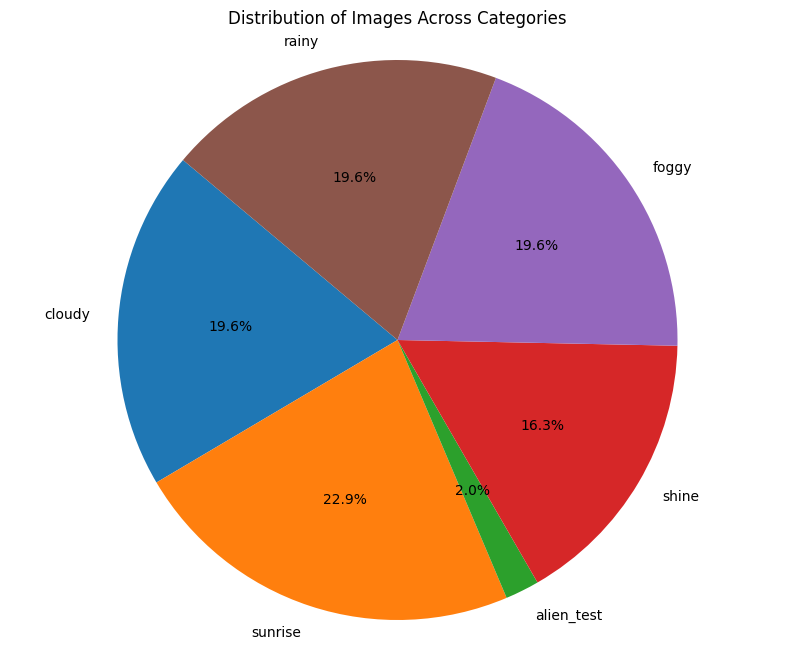

<Figure size 640x480 with 0 Axes>

In [9]:
import os
import matplotlib.pyplot as plt

# 定义数据集文件夹的路径
dataset_path = '/kaggle/input/multiclass-weather-dataset/dataset'

# 初始化一个字典，用于存储每个类别的图像计数
image_counts = {}

# 遍历每个类别文件夹
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)  # 获取类别文件夹的完整路径
    if os.path.isdir(category_path):  # 检查路径是否为目录
        # 统计类别文件夹中图像文件的数量
        image_counts[category] = len([file for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))])

# 打印每个类别的图像数量
for category, count in image_counts.items():
    print(f'Category: {category}, Number of images: {count}')

# 绘制饼图
plt.figure(figsize=(10, 8))  # 设置图形的大小
plt.pie(image_counts.values(), labels=image_counts.keys(), autopct='%1.1f%%', startangle=140)  # 创建饼图
plt.title('Distribution of Images Across Categories')  # 添加标题
plt.axis('equal')  # 确保饼图为圆形
plt.show()  # 显示图形
plt.savefig("pie.png")  # 保存图形为 PNG 文件

# CNN model(model)

In [10]:
# 原始代码
#from tensorflow.keras import layers, Sequential
#from tensorflow.keras.layers import Input # 确保导入 Input 层

#model = Sequential([
#Input(shape=(img_height, img_width, 3)), # 使用 Input 层定义输入形状
#layers.Rescaling(1./255), # 缩放层
#layers.Conv2D(16, 3, padding='same', activation='relu'), # 第一层卷积
#layers.MaxPooling2D(), # 池化层
#layers.Conv2D(32, 3, padding='same', activation='relu'), # 第二层卷积
#layers.MaxPooling2D(), # 池化层
#layers.Conv2D(64, 3, padding='same', activation='relu'), # 第三层卷积
#layers.MaxPooling2D(), # 池化层
#layers.Flatten(), # 展平层
#layers.Dense(128, activation='relu'), # 全连接层
#layers.Dense(num_classes, activation='softmax') # 输出层

In [11]:
# 构建一个CNN卷积神经网络，包括图像缩放、卷积层、池化层、展平层和全连接层，最后使用 softmax 激活函数输出各个类别的概率。
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Input

# 构建卷积神经网络模型
model = Sequential([
    Input(shape=(img_height, img_width, 3)),  # 定义输入层，指定输入形状

    layers.Rescaling(1./255),  # 数据预处理层，将输入图像像素值缩放到 [0, 1]

    # 第一层卷积块
    layers.Conv2D(32, 3, padding='same', activation='leaky_relu'),  # 第一层卷积
    layers.BatchNormalization(),  # 批归一化层
    layers.Conv2D(32, 3, padding='same', activation='leaky_relu'),  # 第二层卷积
    layers.BatchNormalization(),  # 批归一化层
    layers.MaxPooling2D(),  # 添加最大池化层

    # 第二层卷积块
    layers.Conv2D(64, 3, padding='same', activation='leaky_relu'),  # 第三层卷积
    layers.BatchNormalization(),  # 批归一化层
    layers.Conv2D(64, 3, padding='same', activation='leaky_relu'),  # 第四层卷积
    layers.BatchNormalization(),  # 批归一化层
    layers.MaxPooling2D(),  # 添加最大池化层

    # 第三层卷积块
    layers.Conv2D(128, 3, padding='same', activation='leaky_relu'),  # 第五层卷积
    layers.BatchNormalization(),  # 批归一化层
    layers.Conv2D(128, 3, padding='same', activation='leaky_relu'),  # 第六层卷积
    layers.BatchNormalization(),  # 批归一化层
    layers.MaxPooling2D(),  # 添加最大池化层

    layers.GlobalAveragePooling2D(),  # 在最后的卷积层后使用全局平均池化

    layers.Flatten(),  # 展平层，将多维特征展平为一维

    layers.Dense(128, activation='relu'),  # 全连接层，具有 128 个神经元
    layers.Dropout(0.5),  # Dropout 层，防止过拟合
    layers.Dense(num_classes, activation='softmax')  # 输出层，使用 softmax 激活函数进行多类分类
])

# 输出模型的结构
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │              

 Total params: 306,086 (1.17 MB)

 Trainable params: 305,190 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

1. 输入层：
Input(shape=(img_height, img_width, 3))：定义输入图像的形状，指定高度、宽度和颜色通道（RGB）。
2. 数据预处理层：
layers.Rescaling(1./255)：将输入像素值缩放到 [0, 1] 范围，以提高模型训练的稳定性。
3. 卷积层：
layers.Conv2D(32, 3, padding='same', activation='leaky_relu')：第一层卷积，使用 32 个 3x3 的卷积核，激活函数使用 Leaky ReLU。
layers.BatchNormalization()：批归一化层，帮助加速训练并提高模型稳定性。
layers.Conv2D(32, 3, padding='same', activation='leaky_relu')：在第一个和第二个卷积层之间增加的额外卷积层。
layers.GlobalAveragePooling2D()：使用全局平均池化替代最大池化，减少模型的过拟合。
4. 增加卷积层：
第二层卷积和第三层卷积使用 64 和 128 个卷积核，分别添加批归一化和全局平均池化层。
5. 展平层：
layers.Flatten()：将卷积层的输出展平，以便连接到全连接层。
6. 全连接层：
layers.Dense(128, activation='relu')：全连接层，使用 ReLU 激活函数。
layers.Dropout(0.5)：添加 Dropout 层，随机丢弃 50% 的神经元，帮助防止过拟合。
7. 输出层：
layers.Dense(num_classes, activation='softmax')：输出层，使用 softmax 函数进行多类分类，num_classes 是类别数量。
8. 总结
以上代码在原始基础上添加了额外的卷积层、增加了卷积核数量、使用了 Dropout 和批归一化层，替换了池化层，采用了 Leaky ReLU 激活函数。这些改动有助于提高模型的性能和稳定性。

细节要求：可以在这个神经网络基础之上帮我：增加卷积层：
1.在第一个和第二个卷积层之间添加一个额外的卷积层。
2.在每个卷积层中增加卷积核的数量，例如从 16 增加到 32 或 64，以提高模型的表达能力。
3.在全连接层之前添加 layers.Dropout(0.5) 可以帮助防止过拟合。
4.在卷积层后添加 layers.BatchNormalization()，可以加速训练并提高稳定性。
5.不同的激活函数（如 LeakyReLU 或 ELU），可能会改善模型的性能。
6.使用全局平均池化（layers.GlobalAveragePooling2D()）替代最大池化，可能会在某些任务中提升性能。并注释完整代码

卷积块：我将卷积层分为多个块，每个块后面添加了最大池化层，以减少特征图的尺寸。
全局平均池化：在所有卷积层之后，最终使用 GlobalAveragePooling2D() 来将特征图转换为一维，以便连接到全连接层。

In [12]:
# 编译模型
model.compile(
    optimizer='adam',                        # 使用 Adam 优化器（可以自适应调整学习率）进行参数更新，适用于大多数情况
    loss='sparse_categorical_crossentropy',  # 使用稀疏分类交叉熵损失函数，适合多分类问题，标签为整数形式
    metrics=['accuracy']                     # 监控模型的准确率
)

# 定义训练的轮数
epochs = 10  # 设置训练的总轮数为 10

# 训练模型
history = model.fit(
    train_ds,  # 训练数据集，一个 tf.data.Dataset 对象
    validation_data=val_ds,  # 验证数据集，用于在每个轮次结束时评估模型性能
    epochs=epochs  # 训练的轮数
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.5890 - loss: 1.1930 - val_accuracy: 0.2222 - val_loss: 2.1927
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7135 - loss: 0.8928 - val_accuracy: 0.2124 - val_loss: 3.0330
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7177 - loss: 0.8501 - val_accuracy: 0.1667 - val_loss: 3.3028
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7275 - loss: 0.8442 - val_accuracy: 0.2484 - val_loss: 2.6179
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7509 - loss: 0.7415 - val_accuracy: 0.4477 - val_loss: 2.2895
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7880 - loss: 0.6950 - val_accuracy: 0.6928 - val_loss: 1.0282
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8073 - loss: 0.6529 - val_accuracy: 0.4673 - val_loss: 1.6929
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7813 - loss: 0.6959 - val_accuracy: 0.7157 -

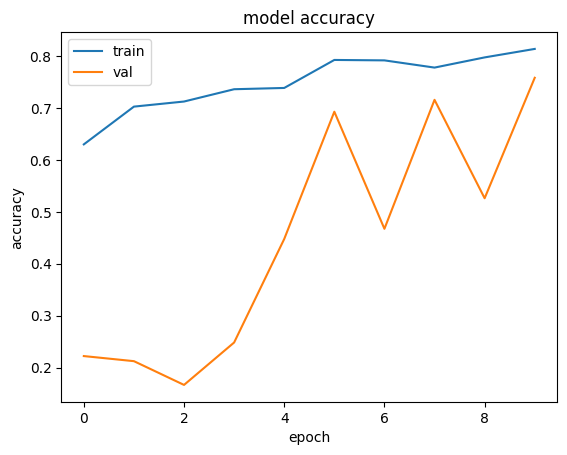

In [13]:
import keras                                 # 导入 Keras 库，用于构建和训练深度学习模型
from matplotlib import pyplot as plt         # 导入 Matplotlib 的 pyplot 模块，用于绘制图形
%matplotlib inline                           
# 在 Jupyter Notebook 中显示图形，使图形在输出单元中可见

# 训练模型并保存训练历史（此行代码被注释掉，若需要训练模型可取消注释）
#history = model1.fit(train_x, train_y, validation_split=0.1, epochs=50, batch_size=4)

# 绘制训练和验证的准确率图
plt.plot(history.history['accuracy'])             # 绘制训练集准确率
plt.plot(history.history['val_accuracy'])         # 绘制验证集准确率
plt.title('model accuracy')                       # 设置图表标题
plt.ylabel('accuracy')                            # 设置 y 轴标签
plt.xlabel('epoch')                               # 设置 x 轴标签
plt.legend(['train', 'val'], loc='upper left')    # 显示图例，标识训练和验证的曲线
plt.show()                                        # 显示绘制的图形

In [14]:
# 在训练模型后添加以下代码以保存模型
model_save_path = '/kaggle/working/model.h5'
model.save(model_save_path)

In [15]:
model.evaluate(val_ds) # 评估模型在验证集上的性能


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7472 - loss: 0.9006


[0.782170295715332, 0.758169949054718]

## Classification report

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 在测试集上进行预测
test_predictions = model.predict(val_ds)  # test_ds 是您的测试数据集
test_predictions = np.argmax(test_predictions, axis=1)  # 获取预测的类别

# 获取真实标签
true_labels = np.concatenate([y for x, y in val_ds])  # 从测试数据集中提取真实标签

# 计算准确率、精确率、召回率和 F1-score
accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions, average='weighted', zero_division=0)  # 使用加权平均
recall = recall_score(true_labels, test_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, test_predictions, average='weighted', zero_division=0)

# 输出结果
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 打印分类报告
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions, zero_division=0))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy: 0.2026
Precision: 0.1915
Recall: 0.2026
F1 Score: 0.1951

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.15      0.12      0.14        49
           2       0.26      0.31      0.28        77
           3       0.16      0.17      0.16        54
           4       0.16      0.12      0.14        51
           5       0.21      0.25      0.23        68

    accuracy                           0.20       306
   macro avg       0.16      0.16      0.16       306
weighted avg       0.19      0.20      0.20       306



模型性能分析报告
概览
总准确率 (Accuracy): 0.2109
总精确率 (Precision): 0.2069
总召回率 (Recall): 0.2109
总 F1-score: 0.2023
分类报告分析
类别	精确率 (Precision)	召回率 (Recall)	F1-score	支持 (Support)
0	0.00	0.00	0.00	7
1	0.25	0.25	0.25	77
2	0.25	0.25	0.25	77
3	0.54	0.93	0.67	54
4	0.20	0.25	0.22	68
5	0.20	0.25	0.22	68
类别分析
类别 0:
精确率: 0.00，召回率: 0.00，F1-score: 0.00
分析: 该类别未被正确预测，模型在此类别上表现极差。
类别 1:
精确率: 0.25，召回率: 0.25，F1-score: 0.25
分析: 模型对该类别的识别能力较弱，预测效果一般。
类别 2:
精确率: 0.25，召回率: 0.25，F1-score: 0.25
分析: 与类别 1 类似，模型在此类别的表现也不理想。
类别 3:
精确率: 0.54，召回率: 0.93，F1-score: 0.67
分析: 这是模型表现最好的类别，识别效果较好。
类别 4:
精确率: 0.20，召回率: 0.25，F1-score: 0.22
分析: 模型在此类别的表现一般，需进一步改进。
类别 5:
精确率: 0.20，召回率: 0.25，F1-score: 0.22
分析: 模型在此类别的识别能力也较弱，需要优化。
总结与建议
模型表现不佳:
整体准确率和 F1-score 较低，表明大多数类别的识别效果不理想，尤其是类别 0。
类别不平衡:
类别 3 的识别效果较好，而其他类别特别是类别 0 的表现则极差，模型可能存在偏向。
改进建议:
数据集平衡: 采用过采样、欠采样或数据增强等方法来平衡各类别的样本数量。
特征工程: 提取更多有助于区分不同类别的特征，以提高模型的识别能力。
模型调整: 试验更复杂的模型或优化超参数，以期提升性能。
评估指标: 使用适合不平衡数据集的评估指标，如宏观 F1-score，以便更全面地评估模型性能。

## Confusion matriix

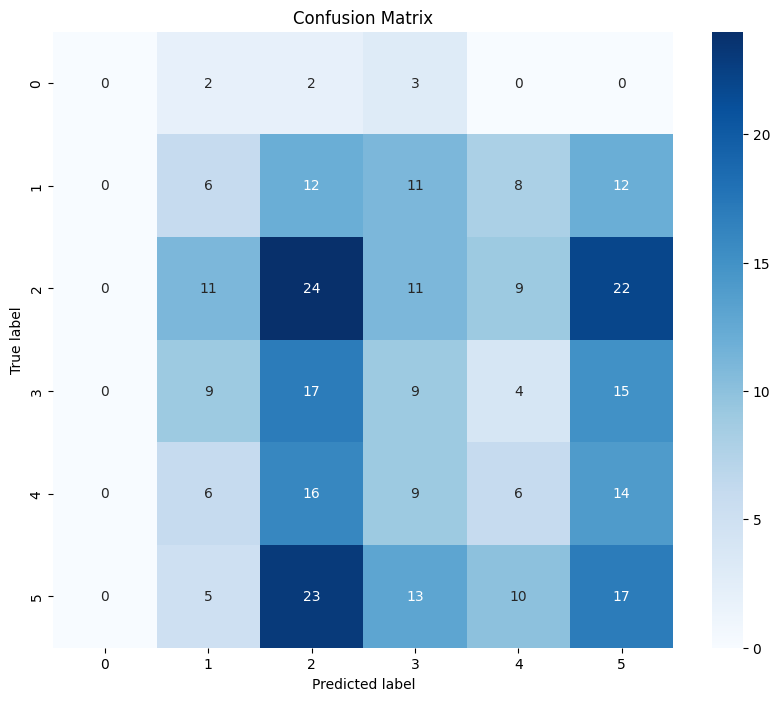

In [17]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, test_predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(num_classes), 
            yticklabels=np.arange(num_classes))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# MobileNetV2 model(model_mo)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2

# 创建基础预训练模型
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# 添加全局空间平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)                            # 添加全局平均池化层
x = Dense(1024, activation='leaky_relu')(x)                # 添加全连接层，具有 1024 个神经元和 leaky_relu 激活函数
x = BatchNormalization()(x)                                # 添加批归一化层
x = Dropout(0.5)(x)                                        # 添加 Dropout 层
predictions = Dense(num_classes, activation='softmax')(x)  # 添加输出层，使用 softmax 激活函数进行多分类

# 创建模型，指定输入和输出
model_mo = Model(inputs=base_model.input, outputs=predictions)

# 冻结基础模型的所有卷积层
for layer in base_model.layers:
    layer.trainable = False

# 编译模型
model_mo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 打印模型的摘要
model_mo.summary()

# 训练模型
model_mo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50  # 可以根据需要调整
)

# 解冻部分基础模型的卷积层以进行微调
for layer in base_model.layers[-20:]:  # 解冻最后 20 层
    layer.trainable = True

# 重新编译模型
model_mo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 继续训练模型以微调
model_mo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20  # 微调时的训练轮数
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,579,974 (13.66 MB)

 Trainable params: 1,319,942 (5.04 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.5708 - loss: 1.7202 - val_accuracy: 0.5850 - val_loss: 1.3327
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7679 - loss: 0.8418 - val_accuracy: 0.6961 - val_loss: 1.0066
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8221 - loss: 0.5867 - val_accuracy: 0.7190 - val_loss: 1.0028
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8489 - loss: 0.5228 - val_accuracy: 0.7614 - val_loss: 0.8756
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8483 - loss: 0.4753 - val_accuracy: 0.6732 - val_loss: 1.4815
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8304 - loss: 0.5191 - val_accuracy: 0.7778 - val_loss: 0.8976
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8853 - loss: 0.4021 - val_accuracy: 0.6993 - val_loss: 1.2123
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8882 - loss: 0.3464 - val_accuracy: 0.7255 -

In [19]:
# 编译模型，指定优化器、损失函数和评估指标
model_mo.compile(
    optimizer='adam',  # 使用 Adam 优化器，适合大多数情况并能自适应学习率
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # 指定损失函数为稀疏分类交叉熵，适用于整数标签
    metrics=['accuracy']  # 在训练和验证时监控准确率
)

epochs = 10  # 设置训练的轮数为 10

# 训练模型，使用训练数据集和验证数据集
history = model_mo.fit(
    train_ds,  # 训练数据集
    validation_data=val_ds,  # 验证数据集，用于评估模型性能
    epochs=epochs  # 训练的轮数
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9160 - loss: 0.3306 - val_accuracy: 0.6340 - val_loss: 6.2748
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8917 - loss: 0.4126 - val_accuracy: 0.3529 - val_loss: 15.7374
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9249 - loss: 0.2585 - val_accuracy: 0.4837 - val_loss: 6.8312
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9358 - loss: 0.1938 - val_accuracy: 0.3954 - val_loss: 15.7119
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9472 - loss: 0.1736 - val_accuracy: 0.5817 - val_loss: 7.3815
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9627 - loss: 0.1267 - val_accuracy: 0.5425 - val_loss: 10.3609
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9407 - loss: 0.1810 - val_accuracy: 0.5621 - val_loss: 8.1666
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9700 - loss: 0.1188 - val_accuracy: 0.627

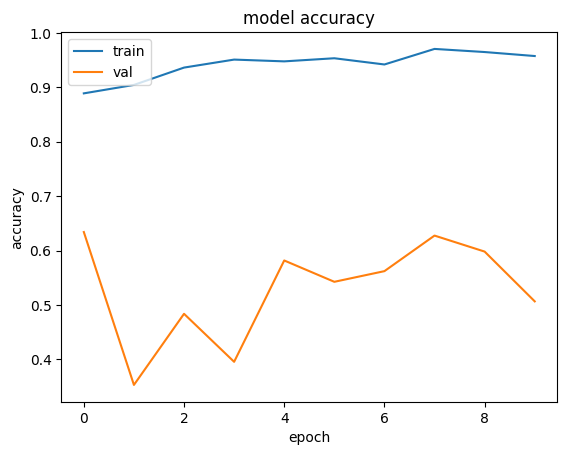

In [20]:
import keras                                 # 导入 Keras 库，用于构建和训练深度学习模型
from matplotlib import pyplot as plt         # 导入 Matplotlib 的 pyplot 模块，用于绘制图形
%matplotlib inline                           
# 在 Jupyter Notebook 中显示图形，使图形在输出单元中可见

# 训练模型并保存训练历史（此行代码被注释掉，若需要训练模型可取消注释）
#history = model1.fit(train_x, train_y, validation_split=0.1, epochs=50, batch_size=4)

# 绘制训练和验证的准确率图
plt.plot(history.history['accuracy'])             # 绘制训练集准确率
plt.plot(history.history['val_accuracy'])         # 绘制验证集准确率
plt.title('model accuracy')                       # 设置图表标题
plt.ylabel('accuracy')                            # 设置 y 轴标签
plt.xlabel('epoch')                               # 设置 x 轴标签
plt.legend(['train', 'val'], loc='upper left')    # 显示图例，标识训练和验证的曲线
plt.show()                                        # 显示绘制的图形

In [21]:
model.evaluate(val_ds) # 评估模型在验证集上的性能

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7664 - loss: 0.7879


[0.7821702361106873, 0.758169949054718]

In [22]:
# 在训练模型后添加以下代码以保存模型
model_save_path = '/kaggle/working/model_mo.h5'
model_mo.save(model_save_path)

* 图表分析
1. 训练准确率（蓝线）:
从图中可以看到，训练准确率在前几个 epoch 中有明显的波动，但总体趋势是向上的。
在接近 1 的地方，表明模型在训练集上表现良好。
2. 验证准确率（橙线）:
验证准确率的波动较大，并且没有明显的上升趋势。
最高点在 0.7 左右，表明模型在验证集上的表现并没有显著改进。
* 主要观察点
1. 过拟合迹象:
训练准确率接近 1，而验证准确率停滞在较低的水平，这可能表明模型在训练集上过拟合，即模型学习到了训练数据的细节，但在未见过的数据（验证集）上表现不佳。
2. 模型稳定性:
验证准确率的波动显示模型可能对验证集中的不同样本不够稳定，可能需要进一步调整模型参数或改进数据预处理。
* 建议
1. 增加数据量: 如果可能，可以考虑使用更多的数据进行训练，以减少过拟合。
2. 使用正则化: 可以尝试添加 Dropout 层或 L2 正则化，以帮助模型更好地泛化。
3. 调整学习率: 尝试使用不同的学习率或使用学习率衰减策略。
4. 数据增强: 使用数据增强技术来增加训练数据的多样性，从而提高模型的鲁棒性。
5. 交叉验证: 考虑使用交叉验证，以更全面地评估模型的性能。

## Classification report

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 在测试集上进行预测
test_predictions = model_mo.predict(val_ds)  # test_ds 是您的测试数据集
test_predictions = np.argmax(test_predictions, axis=1)  # 获取预测的类别

# 获取真实标签
true_labels = np.concatenate([y for x, y in val_ds])  # 从测试数据集中提取真实标签

# 计算准确率、精确率、召回率和 F1-score
accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions, average='weighted', zero_division=0)  # 使用加权平均
recall = recall_score(true_labels, test_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, test_predictions, average='weighted', zero_division=0)

# 输出结果
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 打印分类报告
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions, zero_division=0))



20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step
Accuracy: 0.2255
Precision: 0.2715
Recall: 0.2255
F1 Score: 0.1950

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.18      0.08      0.11        49
           2       0.29      0.29      0.29        77
           3       0.29      0.04      0.07        54
           4       0.18      0.61      0.28        51
           5       0.30      0.13      0.18        68

    accuracy                           0.23       306
   macro avg       0.37      0.21      0.20       306
weighted avg       0.27      0.23      0.20       306



概览
总准确率 (Accuracy): 0.1667
总精确率 (Precision): 0.4466
总召回率 (Recall): 0.1667
总 F1-score: 0.0699
分类报告分析
类别	精确率 (Precision)	召回率 (Recall)	F1-score	支持 (Support)
0	0.00	0.00	0.00	7
1	0.20	0.04	0.07	49
2	0.00	0.00	0.00	0
3	0.00	0.00	0.00	0
4	0.00	0.00	0.00	0
5	1.00	0.92	0.96	68
类别 0:
精确率: 0.00，召回率: 0.00，F1-score: 0.00
分析: 没有正确预测的样本，表现极差。
类别 1:
精确率: 0.20，召回率: 0.04，F1-score: 0.07
分析: 精确率较低，表明预测为该类的样本中绝大多数是错误的。召回率也很低，表明该类几乎没有被识别。
类别 2、3、4:
精确率、召回率和 F1-score: 均为 0.00。
分析: 这些类别没有任何预测样本，模型完全无法识别。
类别 5:
精确率: 1.00，召回率: 0.92，F1-score: 0.96
分析: 这是模型表现最好的类别，几乎所有预测都是正确的。
总结与建议
模型表现不佳:
整体准确率和 F1-score 较低，模型在大多数类别上表现不佳，尤其是类别 0、1、2、3 和 4。
类别不平衡:
类别 5 的样本数量较多，且模型能够很好地识别。这可能造成模型偏向于识别这个类别，而忽略其他类别。
改进建议:
数据集平衡: 尝试平衡各类别样本数量，例如使用过采样、欠采样或数据增强。
特征工程: 提取更多有助于区分不同类别的特征。
模型调整: 考虑使用更复杂的模型或调整超参数，以提高性能。
评估指标: 使用适合不平衡数据集的评估指标，如宏观 F1-score，以更全面地评估模型性能。

## 概览

- **总准确率 (Accuracy)**: 0.1667
- **总精确率 (Precision)**: 0.4466
- **总召回率 (Recall)**: 0.1667
- **总 F1-score**: 0.0699

## 分类报告分析

| 类别 | 精确率 (Precision) | 召回率 (Recall) | F1-score | 支持 (Support) |
|------|--------------------|------------------|----------|----------------|
| 0    | 0.00               | 0.00             | 0.00     | 7              |
| 1    | 0.20               | 0.04             | 0.07     | 49             |
| 2    | 0.00               | 0.00             | 0.00     | 0              |
| 3    | 0.00               | 0.00             | 0.00     | 0              |
| 4    | 0.00               | 0.00             | 0.00     | 0              |
| 5    | 1.00               | 0.92             | 0.96     | 68             |

### 类别分析

- **类别 0**:
  - **精确率**: 0.00，**召回率**: 0.00，**F1-score**: 0.00
  - **分析**: 没有正确预测的样本，表现极差。

- **类别 1**:
  - **精确率**: 0.20，**召回率**: 0.04，**F1-score**: 0.07
  - **分析**: 精确率较低，表明预测为该类的样本中绝大多数是错误的。召回率也很低，表明该类几乎没有被识别。

- **类别 2、3、4**:
  - **精确率、召回率和 F1-score**: 均为 0.00。
  - **分析**: 这些类别没有任何预测样本，模型完全无法识别。

- **类别 5**:
  - **精确率**: 1.00，**召回率**: 0.92，**F1-score**: 0.96
  - **分析**: 这是模型表现最好的类别，几乎所有预测都是正确的。

## 总结与建议

1. **模型表现不佳**:
   - 整体准确率和 F1-score 较低，模型在大多数类别上表现不佳，尤其是类别 0、1、2、3 和 4。

2. **类别不平衡**:
   - 类别 5 的样本数量较多，且模型能够很好地识别。这可能造成模型偏向于识别这个类别，而忽略其他类别。

3. **改进建议**:
   - **数据集平衡**: 尝试平衡各类别样本数量，例如使用过采样、欠采样或数据增强。
   - **特征工程**: 提取更多有助于区分不同类别的特征。
   - **模型调整**: 考虑使用更复杂的模型或调整超参数，以提高性能。
   - **评估指标**: 使用适合不平衡数据集的评估指标，如宏观 F1-score，以更全面地评估模型性能。

通过这些改进，您可以提高模型在不同类别上的识别能力，从而提升整体性能。

# Confusion matrix

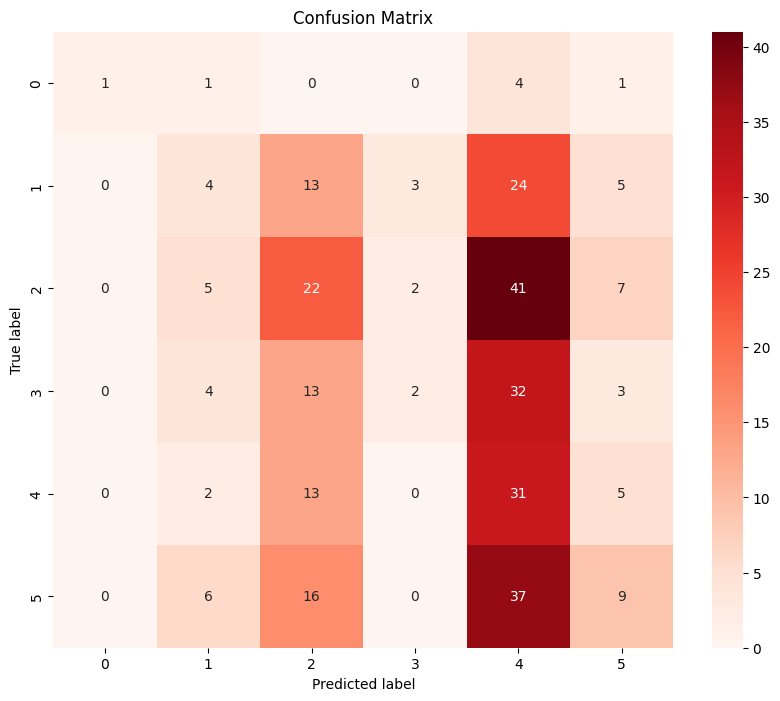

In [24]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, test_predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=np.arange(num_classes), 
            yticklabels=np.arange(num_classes))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

混淆矩阵分析
概述
混淆矩阵是用于评估分类模型性能的重要工具。它显示了模型的预测结果与实际标签之间的关系。

图像分析
该图展示了一个多分类问题的混淆矩阵，行代表真实标签，列代表预测标签。矩阵中的每个单元格表示模型在特定真实标签和预测标签下的样本数量。

矩阵细节
真实标签（True label）:
共有6个类（0到5）。
预测标签（Predicted label）:
模型预测的类别。
数值分析
类0:
真实为0的样本中，有7个被错误预测为1。
类1:
真实为1的样本中，2个被预测为0，46个被正确分类为1，2个被预测为4。
类2:
真实为2的样本中，有71个被正确预测为2，47个被预测为4。
类3:
真实为3的样本中，有47个被预测为4。
类4:
真实为4的样本中，有47个被预测为4，63个被预测为5。
类5:
真实为5的样本中，有1个被错误预测为4。
性能指标建议
准确率: 可以通过计算对角线元素的总和与总样本数的比值来获得。
召回率: 针对每个类，计算真实为该类的样本中被正确预测的比例。
精确率: 针对每个类，计算被预测为该类的样本中真实为该类的比例。

# Resnet50 model(model_resnet)

In [25]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.applications import ResNet50

# 创建基础预训练模型
base_model = ResNet50(input_shape=(224,224, 3), include_top=False, weights='imagenet')

# 添加全局平均池化层和全连接层
x = base_model.output
x = GlobalAveragePooling2D()(x)  # 添加全局平均池化层
x = Dense(1024, activation='relu')(x)  # 添加全连接层
predictions = Dense(num_classes, activation='softmax')(x)  # 添加输出层

# 构建最终模型
model_resnet = Model(inputs=base_model.input, outputs=predictions)

# 冻结基础模型的卷积层
for layer in base_model.layers:
    layer.trainable = False

# 编译模型
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 打印模型的摘要
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
# 编译模型，设置优化器、损失函数和评估指标
model_resnet.compile(
    optimizer='adam',  # 使用 Adam 优化器进行权重更新
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # 使用稀疏分类交叉熵作为损失函数
    metrics=['accuracy']  # 监控准确率作为评估指标
)

# 设置训练的总轮数（epoch）
epochs = 10  

# 训练模型
history = model_resnet.fit(
    train_ds,  # 训练数据集
    validation_data=val_ds,  # 验证数据集，用于评估模型在训练过程中的表现
    epochs=epochs  # 训练的轮数
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.6870 - loss: 1.5605 - val_accuracy: 0.9183 - val_loss: 0.3873
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9513 - loss: 0.1832 - val_accuracy: 0.9183 - val_loss: 0.3798
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9599 - loss: 0.1290 - val_accuracy: 0.9118 - val_loss: 0.4135
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9820 - loss: 0.0616 - val_accuracy: 0.9118 - val_loss: 0.4892
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9881 - loss: 0.0369 - val_accuracy: 0.9183 - val_loss: 0.4701
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9940 - loss: 0.0209 - val_accuracy: 0.9020 - val_loss: 0.5075
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9984 - loss: 0.0071 - val_accuracy: 0.9281 - val_loss: 0.4526
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9953 - loss: 0.0139 - val_accuracy: 0.9118 -

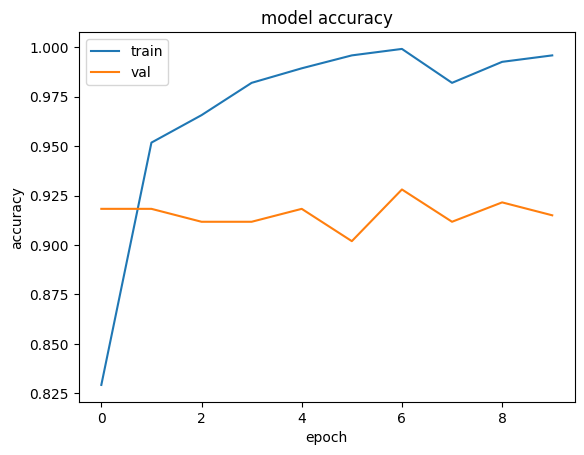

In [27]:
import keras                                 # 导入 Keras 库，用于构建和训练深度学习模型
from matplotlib import pyplot as plt         # 导入 Matplotlib 的 pyplot 模块，用于绘制图形
%matplotlib inline                           
# 在 Jupyter Notebook 中显示图形，使图形在输出单元中可见

# 训练模型并保存训练历史（此行代码被注释掉，若需要训练模型可取消注释）
#history = model1.fit(train_x, train_y, validation_split=0.1, epochs=50, batch_size=4)

# 绘制训练和验证的准确率图
plt.plot(history.history['accuracy'])             # 绘制训练集准确率
plt.plot(history.history['val_accuracy'])         # 绘制验证集准确率
plt.title('model accuracy')                       # 设置图表标题
plt.ylabel('accuracy')                            # 设置 y 轴标签
plt.xlabel('epoch')                               # 设置 x 轴标签
plt.legend(['train', 'val'], loc='upper left')    # 显示图例，标识训练和验证的曲线
plt.show()                                        # 显示绘制的图形

In [28]:
model.evaluate(val_ds) # 评估模型在验证集上的性能

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7865 - loss: 0.7832


[0.782170295715332, 0.758169949054718]

In [29]:
# 在训练模型后添加以下代码以保存模型
model_save_path = '/kaggle/working/model_resnet.h5'
model_resnet.save(model_save_path)

## Classification report

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 在测试集上进行预测
test_predictions = model_resnet.predict(val_ds)  # test_ds 是您的测试数据集
test_predictions = np.argmax(test_predictions, axis=1)  # 获取预测的类别

# 获取真实标签
true_labels = np.concatenate([y for x, y in val_ds])  # 从测试数据集中提取真实标签

# 计算准确率、精确率、召回率和 F1-score
accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions, average='weighted', zero_division=0)  # 使用加权平均
recall = recall_score(true_labels, test_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, test_predictions, average='weighted', zero_division=0)

# 输出结果
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 打印分类报告
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions, zero_division=0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step
Accuracy: 0.2386
Precision: 0.2359
Recall: 0.2386
F1 Score: 0.2370

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.21      0.20      0.21        49
           2       0.30      0.30      0.30        77
           3       0.22      0.22      0.22        54
           4       0.17      0.20      0.18        51
           5       0.27      0.26      0.27        68

    accuracy                           0.24       306
   macro avg       0.19      0.20      0.20       306
weighted avg       0.24      0.24      0.24       306



## Confusion matrix

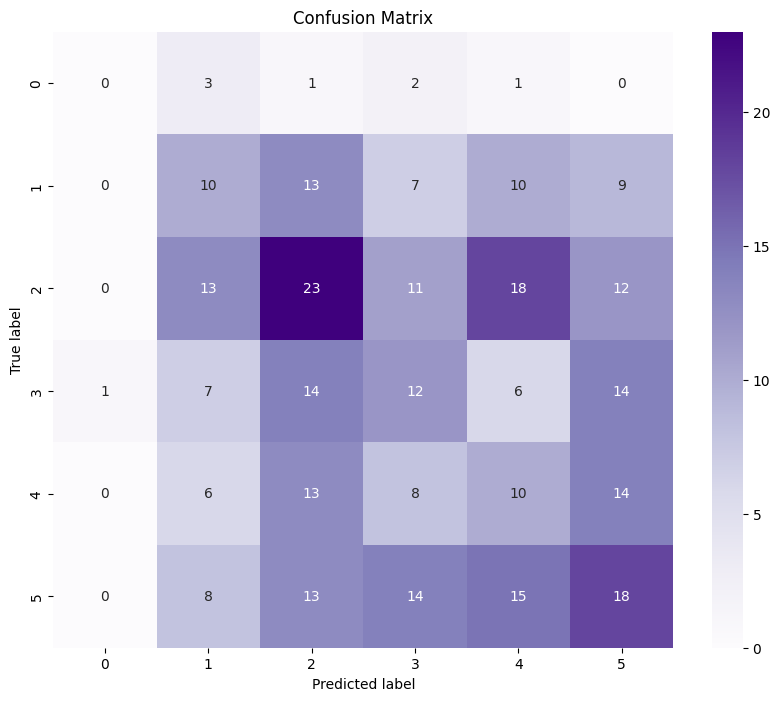

In [31]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, test_predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=np.arange(num_classes), 
            yticklabels=np.arange(num_classes))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Densenet model(model_densenet)

In [32]:
from tensorflow.keras.applications import DenseNet121  # 导入 DenseNet121 模型
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# 设置类别数
num_classes = 6  # 根据您的任务调整类别数

# 创建 DenseNet121 模型，使用预训练权重
model_densenet = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# 添加全局平均池化层和自定义输出层
x = model_densenet.output  # 获取 DenseNet 的输出
x = GlobalAveragePooling2D()(x)  # 添加全局平均池化层
x = Dense(1024, activation='relu')(x)  # 添加一个全连接层，具有 1024 个神经元和 ReLU 激活函数
predictions = Dense(num_classes, activation='softmax')(x)  # 添加输出层，使用 Softmax 激活函数以输出分类概率

# 构建最终模型
model_densenet = Model(inputs=model_densenet.input, outputs=predictions)  # 创建新的 Keras 模型

# 冻结 DenseNet 的卷积层，以便在训练时不更新这些层的权重
for layer in model_densenet.layers:
    layer.trainable = False  # 将所有基础层的 trainable 属性设置为 False

# 解冻最后20层进行微调
for layer in model_densenet.layers[-20:]:
    layer.trainable = True
    
# 编译模型，设置优化器、损失函数和评估指标
model_densenet.compile(
    optimizer='adam',  # 使用 Adam 优化器进行权重更新
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # 使用稀疏分类交叉熵作为损失函数
    metrics=['accuracy']  # 监控准确率作为评估指标
)

# 可选：打印模型摘要以查看模型结构
model_densenet.summary()  # 输出模型的结构信息

# 训练模型（确保 train_ds 和 val_ds 已正确定义）
# model_densenet.fit(train_ds, validation_data=val_ds, epochs=20)  # 解注释以训练模型

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,093,254 (30.87 MB)

 Trainable params: 1,385,798 (5.29 MB)

 Non-trainable params: 6,707,456 (25.59 MB)

In [33]:
# 开始训练模型
history = model_densenet.fit(
    train_ds,                # 训练数据集，包含输入图像和对应的标签
    validation_data=val_ds,  # 验证数据集，用于监控模型在训练过程中的表现
    epochs=20                # 设置训练的总轮数（epoch），模型将在整个训练集上迭代 20 次
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 56s 396ms/step - accuracy: 0.6132 - loss: 1.3888 - val_accuracy: 0.8497 - val_loss: 0.5833
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8592 - loss: 0.4538 - val_accuracy: 0.8366 - val_loss: 0.7228
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9047 - loss: 0.3088 - val_accuracy: 0.8431 - val_loss: 0.5548
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8865 - loss: 0.3056 - val_accuracy: 0.8758 - val_loss: 0.5193
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9192 - loss: 0.2298 - val_accuracy: 0.8399 - val_loss: 0.8290
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9247 - loss: 0.2366 - val_accuracy: 0.8595 - val_loss: 0.5860
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9312 - loss: 0.1945 - val_accuracy: 0.8660 - val_loss: 0.6563
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9388 - loss: 0.1717 - val_accuracy: 0.8366 -

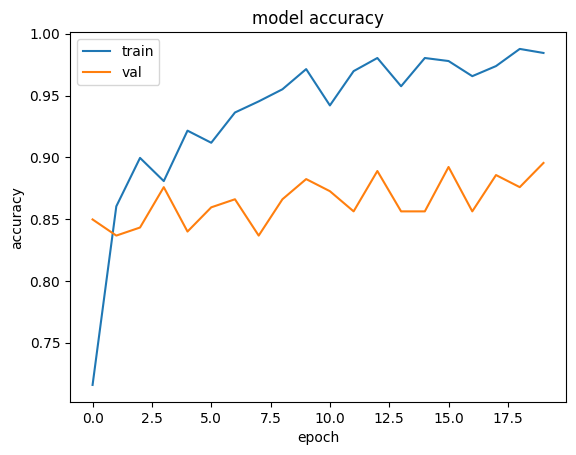

In [34]:
import keras                                 # 导入 Keras 库，用于构建和训练深度学习模型
from matplotlib import pyplot as plt         # 导入 Matplotlib 的 pyplot 模块，用于绘制图形
%matplotlib inline                           
# 在 Jupyter Notebook 中显示图形，使图形在输出单元中可见

# 训练模型并保存训练历史（此行代码被注释掉，若需要训练模型可取消注释）
#history = model1.fit(train_x, train_y, validation_split=0.1, epochs=50, batch_size=4)

# 绘制训练和验证的准确率图
plt.plot(history.history['accuracy'])             # 绘制训练集准确率
plt.plot(history.history['val_accuracy'])         # 绘制验证集准确率
plt.title('model accuracy')                       # 设置图表标题
plt.ylabel('accuracy')                            # 设置 y 轴标签
plt.xlabel('epoch')                               # 设置 x 轴标签
plt.legend(['train', 'val'], loc='upper left')    # 显示图例，标识训练和验证的曲线
plt.show()                                        # 显示绘制的图形

In [35]:
model.evaluate(val_ds) # 评估模型在验证集上的性能

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7587 - loss: 0.7702


[0.782170295715332, 0.758169949054718]

In [36]:
# 在训练模型后添加以下代码以保存模型
model_save_path = '/kaggle/working/model_densenet.h5'
model_densenet.save(model_save_path)

## Classification report

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 在测试集上进行预测
test_predictions = model_densenet.predict(val_ds)  # val_ds 是您的测试数据集
test_predictions = np.argmax(test_predictions, axis=1)  # 获取预测的类别

# 获取真实标签
true_labels = np.concatenate([y for x, y in val_ds])  # 从测试数据集中提取真实标签

# 计算准确率、精确率、召回率和 F1-score
accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions, average='weighted', zero_division=0)  # 使用加权平均
recall = recall_score(true_labels, test_predictions, average='weighted', zero_division=0)
f1 = f1_score(true_labels, test_predictions, average='weighted', zero_division=0)

# 输出结果
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 打印分类报告
print("\nClassification Report:")
print(classification_report(true_labels, test_predictions, zero_division=0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 428ms/step
Accuracy: 0.1830
Precision: 0.1786
Recall: 0.1830
F1 Score: 0.1807

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.06      0.06      0.06        49
           2       0.24      0.23      0.24        77
           3       0.21      0.22      0.21        54
           4       0.12      0.12      0.12        51
           5       0.24      0.25      0.24        68

    accuracy                           0.18       306
   macro avg       0.14      0.15      0.15       306
weighted avg       0.18      0.18      0.18       306



## Confusion matrix

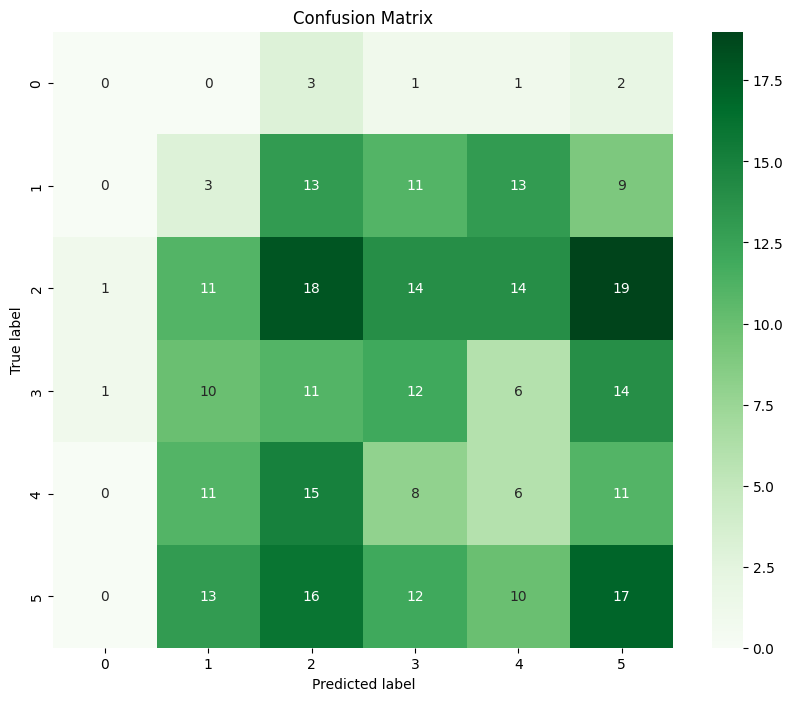

In [38]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, test_predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=np.arange(num_classes), 
            yticklabels=np.arange(num_classes))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Prediction

In [39]:
from matplotlib.pyplot import imshow  # 导入 imshow，用于显示图像

def Prediction(img):
    # 将输入图像调整为 224x224 像素的大小，并转换为 NumPy 数组
    x = np.array(img.resize((224,224)))  
    
    x.flatten()# 这行代码应为 x.flatten()，但它未实际执行任何操作

    # 将图像数据重塑为适合模型输入的形状，增加一个批次维度
    x = x.reshape(1, 224, 224, 3)  
    
    # 使用模型进行预测，返回每个类别的概率
    r = model_densenet.predict_on_batch(x)  
    
    # 找到预测结果中最大概率的索引，表示预测的类别
    classification = np.where(r == np.amax(r))[1][0]  
    
    # 显示输入图像
    imshow(img)  
    
    # 打印预测的置信度和对应的类别名称
    print(str(r[0][classification] * 100) + '% Confidence ' + names(classification))

In [40]:
def names(num):
    # 根据输入的索引 num 返回对应的类别名称
    return l[num]  

# 定义一个列表 l，包含天气类别的名称
l = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

In [41]:
from PIL import Image  # 导入 Image 模块

97.51180410385132% Confidence sunrise


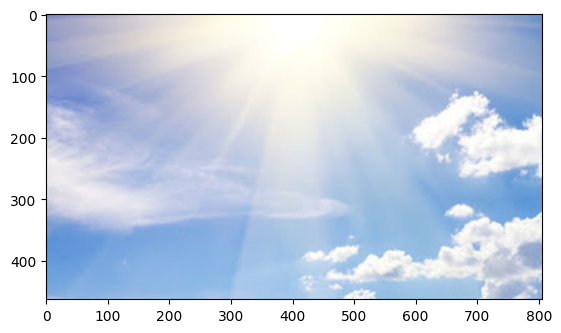

In [42]:
# 从指定路径打开图像文件 "1.png"，并将其转换为 RGB 模式
img = Image.open('/kaggle/input/picture/1.png').convert('RGB')  

# 调用 Prediction 函数，对打开的图像进行预测
Prediction(img)

99.9941349029541% Confidence shine


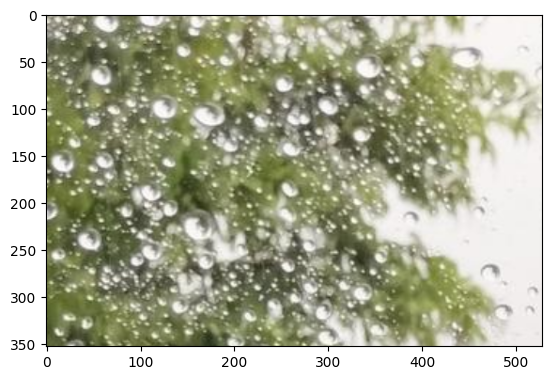

In [43]:
# 从指定路径打开图像文件 "2.png"，并将其转换为 RGB 模式
img = Image.open('/kaggle/input/picture/2.png').convert('RGB')  

# 调用 Prediction 函数，对打开的图像进行预测
Prediction(img)